In [19]:
import sys
import os
import seaborn as sns
sys.path.append("../")
from src.data.load_data import load_all_data, to_dF_F
from scipy.spatial.transform import Rotation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
project_dir = "/Users/anacarolinabotturabarros/PycharmProjects/RSCMINHD/"
animal = 'cohoHDC1_mB1'
session = "2023_03_10/12_51_18"
data_dict = load_all_data(animal,session, project_dir)
img_data = data_dict['img_data']
head_data = data_dict['head_data']
img_time_stamps = data_dict['img_time_stamps']

unit_id    0
frame      0
C          0
dtype: int64
Time Stamp (ms)    0
qw                 0
qx                 0
qy                 0
qz                 0
dtype: int64
Frame Number       0
Time Stamp (ms)    0
Buffer Index       0
dtype: int64


### Calculate dF/F and normalised calcium traces

Still need to figure out what is the best measure to use.

In [4]:
group_by_unit = img_data.groupby('unit_id')
df_units = []
normalised_c = []
for name, unit in group_by_unit:
    dFF = to_dF_F(unit)
    dFF.name = name
    df_units.append(dFF)
    min_C = unit['C'].min()
    max_C = unit['C'].max()
    min_max_norm = (unit['C']- min_C)/(max_C-min_C)
    normalised_c.append(min_max_norm)
    

# pd.concat(df_units, ignore_index=True, axis=1)
img_data['df/f'] = pd.concat(df_units)
img_data['norm_C'] = pd.concat(normalised_c)

## Plot a unit

Plotting some units might give some idea of what we have

<Axes: xlabel='frame', ylabel='norm_C'>

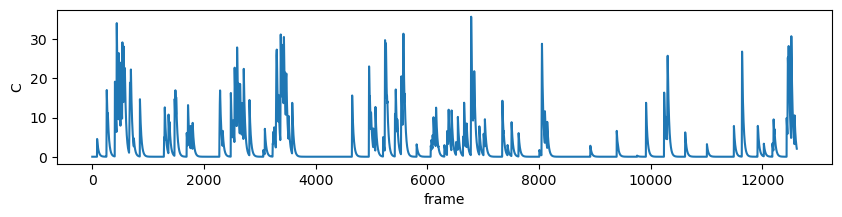

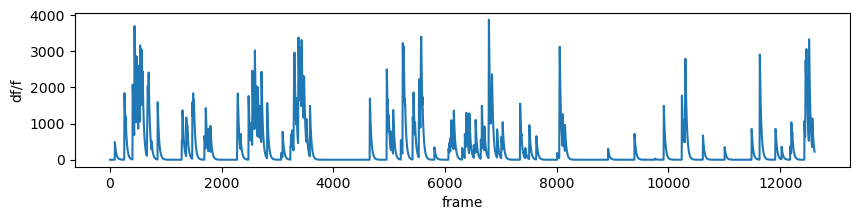

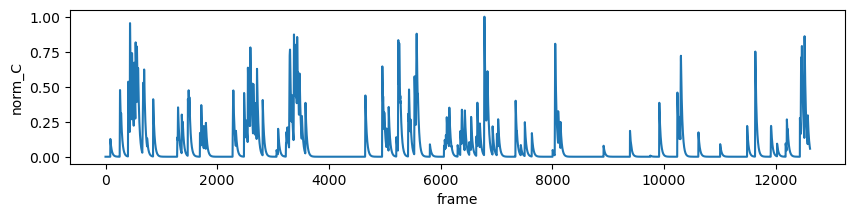

In [5]:
unit = 2

plt.figure(figsize=(10,2))
unit_data = img_data[img_data['unit_id']==img_data['unit_id'].unique()[unit]]
sns.lineplot(data=unit_data, x='frame',y='C')

plt.figure(figsize=(10,2))
unit_data = img_data[img_data['unit_id']==img_data['unit_id'].unique()[unit]]
sns.lineplot(data=unit_data, x='frame',y='df/f')

plt.figure(figsize=(10,2))
unit_data = img_data[img_data['unit_id']==img_data['unit_id'].unique()[unit]]
sns.lineplot(data=unit_data, x='frame',y='norm_C')

## Working with head orientation data

[Text(0, 0.5, 'Direction')]

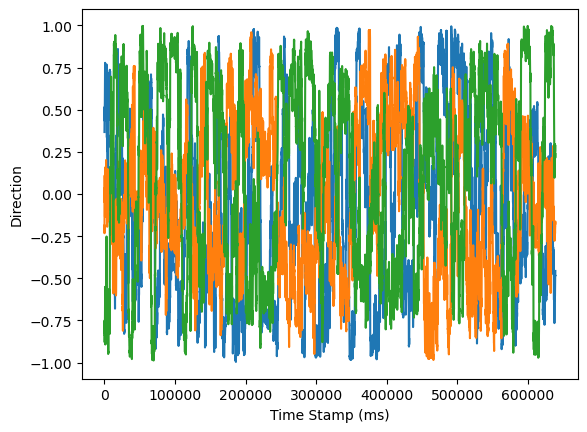

In [6]:
# plot variable from head orientation data
ax = sns.lineplot(data=head_data, x='Time Stamp (ms)',y='qx')
sns.lineplot(data=head_data, x='Time Stamp (ms)',y='qy')
sns.lineplot(data=head_data, x='Time Stamp (ms)',y='qz')
ax.set(ylabel='Direction')

Here we try to bin the different variables into a certain number of bins

In [7]:
bins = 11
head_data['binned_qx'] = pd.cut(head_data['qx'],np.linspace(-1,1,bins))
head_data['binned_qy'] = pd.cut(head_data['qy'],np.linspace(-1,1,bins))
head_data['binned_qz'] = pd.cut(head_data['qz'],np.linspace(-1,1,bins))
head_data['binned_qw'] = pd.cut(head_data['qw'],np.linspace(-1,1,bins))

Here we plot the the count of occurences per bin for each of the variables

Text(0, 0.5, 'Count')

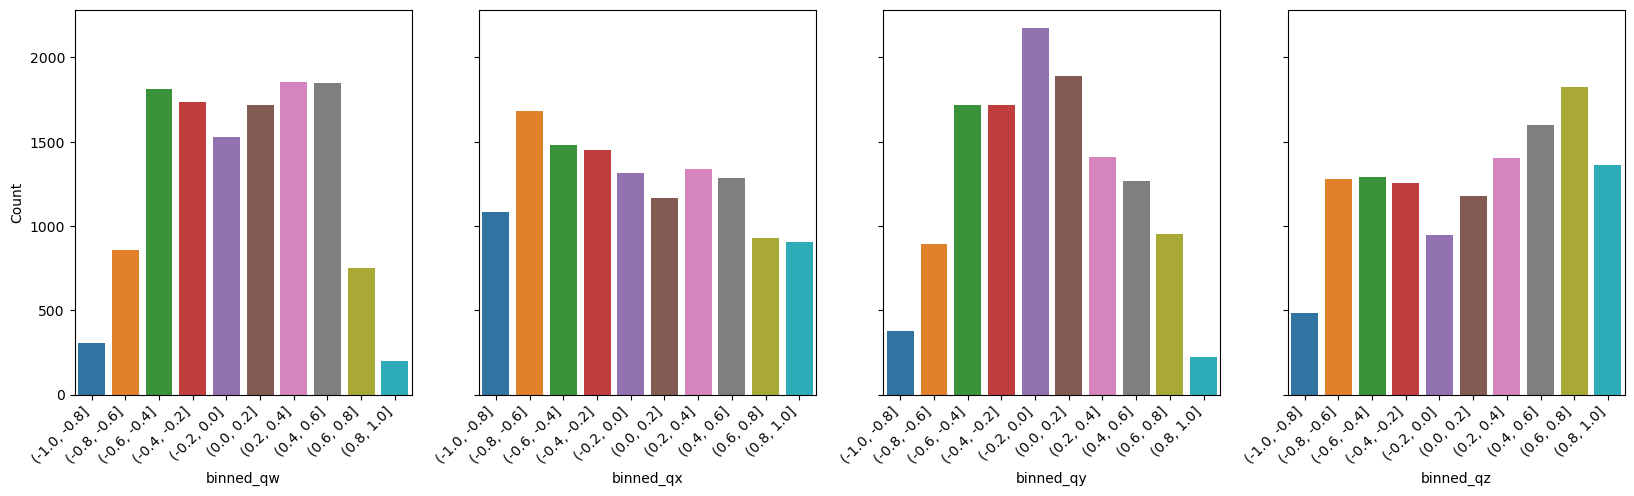

In [8]:

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))
head_qua_vars = head_data.columns[1:]

for ax,var in zip(axs,head_qua_vars):
    p = sns.countplot(x=head_data['binned_'+var], ax=ax)
    ax.set_xticklabels(head_data['binned_qx'].cat.categories, rotation=45, ha='right')
    ax.set(ylabel=None)

axs[0].set_ylabel('Count')

### Transform quartenion data into Euler coordinates

Two ways of calculating the euler angles. One function (adapted to deal with long format data) or the scipy Rotation function.

In [11]:
import math
 
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = [math.atan2(i0, i1) for i0, i1 in zip(t0,t1)]
     
        t2 = +2.0 * (w * y - z * x)
        t2 = [+1.0 if i2 > +1.0 else i2 for i2 in t2]
        t2 = [-1.0 if i2 < -1.0 else i2 for i2 in t2]
        pitch_y = [math.asin(i2) for i2 in t2]
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = [math.atan2(i3, i4) for i3, i4 in zip(t3, t4)]
     
        return roll_x, pitch_y, yaw_z # in radians

In [12]:
x, y, z = euler_from_quaternion(head_data['qx'], head_data['qy'], head_data['qz'], head_data['qw'])
print(x[0],y[0],z[0])

0.037327955424233436 0.8496204042712617 2.2831640727103486


In [15]:
quat = np.array([head_data['qx'], head_data['qy'], head_data['qz'], head_data['qw']])
R = Rotation.from_quat(quat.T)
quat.T.shape
print(quat.T[0])
print(R.as_quat()[0])
euler_data = R.as_euler('xyz', degrees=True)
print(R.as_euler('xyz')[0])

[ 0.367615 -0.186951 -0.825134 -0.386108]
[ 0.36761188 -0.18694941 -0.825127   -0.38610472]
[0.037327   0.8496011  2.28314462]


Combining euler data to original head orientation data and saving it

In [16]:
head_data = pd.concat([head_data, pd.DataFrame(euler_data, columns=['roll_x', 'pitch_y', 'yaw_z'])], axis=1)

In [17]:
# bin euler variables
bins = 61
head_data['binned_roll_x'] = pd.cut(head_data['roll_x'],np.linspace(-180,180,bins))
head_data['binned_pitch_y'] = pd.cut(head_data['pitch_y'],np.linspace(-90,90,bins))
head_data['binned_yaw_z'] = pd.cut(head_data['yaw_z'],np.linspace(-180,180,bins))

In [26]:
head_data['frame'] = head_data.index
head_data.to_csv(os.path.join(project_dir,'data/processed', animal, session,'headOrientationProc.csv'))

## Finding intervals for the different bins

In [29]:
import itertools
from operator import itemgetter

def find_intervals(data):
    ranges =[]    
    for key, group in itertools.groupby(enumerate(data), lambda x:x[0]-x[1]):
        group = list(map(itemgetter(1), group))
        if len(group) > 1:
            ranges.append(pd.Interval(group[0], group[-1],closed='both'))
        # else:
        #     ranges.append(group[0])
    return ranges

def get_intervals(head_data, variable):
    """get frame intervals where angles are within the specified bin

    :param head_data: head orientation data
    :type head_data: pd.DataFrame
    :param variable: name of the variable in head_data to base intervals
    :type variable: str
    :return: intervals of frames with angles between specific groups
    :rtype: dict
    """
    grouped = head_data[[variable,'frame']].groupby(variable)
    intervals = {}
    for name, group in grouped:
        intervals[name] = find_intervals(group['frame'])
    return intervals
     

In [30]:
# Find intervals for one of the quartenion variables
intervals = get_intervals(head_data,'binned_qx')

# Find intervals for yaw_z
intervals_yaw = get_intervals(head_data,'binned_yaw_z')


In [ ]:
# calculate the area under the curve norm_C for each unit between intervals found
units = img_data.groupby('unit_id')

all_auc = pd.DataFrame()

for key, value in intervals.items():
    print(key)
    auc_dict = {}
    for name, unit in units:
        auc=0
        for i in value:
            img_interval = unit[unit['frame'].between(i.left, i.right)]
            auc += np.trapz(img_interval['norm_C'],img_interval['frame'])
        auc_dict[name] = auc
    all_auc[key] = pd.Series(auc_dict)

In [ ]:
all_auc.head()

In [ ]:
interval_lengths = {}
for itv in intervals.keys():
    int_idx = pd.IntervalIndex(intervals[itv])
    total_time = np.sum(int_idx.right - int_idx.left +1)
    interval_lengths[itv] = total_time
    
interval_lengths = pd.Series(interval_lengths, name='interval_lengths')
dir_tuning = all_auc.T.div(interval_lengths, axis=0).T

In [ ]:
# new = dir_tuning.T
# new['unit_id']=dir_tuning.T.index
# new_melt = pd.melt(new, id_vars='unit_id')
# sns.lineplot(x = 'variable', y = 'value', data = new_melt, hue = 'unit_id')

In [ ]:
dir_tuning['unit_id']=dir_tuning.index
new_melt = pd.melt(dir_tuning, id_vars='unit_id')

unit = 5
plot_unit = new_melt[new_melt.unit_id == new_melt.unit_id.iloc[unit]]
ax = sns.lineplot(plot_unit, x=plot_unit.variable.astype(str), y='value')
ax.set_xticklabels(plot_unit.variable.astype(str), rotation=45, ha='right')
ax.set(ylabel='Direction Tunning',xlabel='Direction qx')

In [ ]:
ax = sns.heatmap(dir_tuning.iloc[:,:-1])
ax.set_xticklabels(plot_unit.variable.astype(str), rotation=45, ha='right')
ax.set(ylabel='Units', xlabel='Direction')

In [ ]:
df=dir_tuning.iloc[:,:-1].T
pref_dir = df.idxmax()
pref_dir.value_counts()
ax = sns.countplot(x=pref_dir.values, order=df.index)
ax.set_xticklabels(df.index, rotation=45, ha='right')